# Voorspellen van de benodigde IC-capaciteit over een jaar
---
Binnen dit notebook worden een ARIMA en SARIMA model getraind die de benodigde IC-capaciteit per week tot 1 november 2022 voorspellen. De modellen worden getraind met de benodigde IC-capaciteit tot 1 november 2021 die beschikbaar is gesteld door het NICE (National IC Evaluation). Nadat de modellen getraind zijn worden ze vergeleken met recentere data, van 1 november 2021 tot en met 16 januari 2022. 

## (S)ARIMA
 
ARIMA en SARIMA zijn twee veel gebruikte modellen die worden gebruikt voor forecasting. Binnen deze paragrafen worden beide modellen toegelicht.

### ARIMA
ARIMA staat voor Auto Regressive Integrated Moving Average. Het ARIMA-model maakt een voorspelling op basis van gegevens die het model toegekend krijgt. Een aspect waar een ARIMA-model niet mee kan werken zijn seizoenen. Een ARIMA-model wordt gekenmerkt door de volgende parameters:
* **p**: Geeft de AR-term aan.
* **d**: Geeft het aantal verschillen aan om de data stationair te maken.
* **q**: Geeft de MA-term aan.

#### AR
AR staat zoals eerder aangegeven voor Auto Regressive. Dit geeft aan dat het model de afhankelijke relatie tussen de huidige gegevens en die uit het verleden gebruikt. Met andere woorden, de voorspellingen zijn gebaseerd op waardes uit het verleden.

#### MA
AM staat voor Moving Average. De Moving Average geeft aan dat de voorspelling van het model, de forecast, afhangt van de waardes uit het verleden. Het betekent echter ook dat de fouten in prognoses lineaire functies zijn van fouten uit het verleden. De Moving Average verwijst naar het aantal vertraagde prognosefouten dat in het ARIMA-model moet worden opgenomen.

#### I
Het aantal keer dat differencing op de datasets toegepast moet worden, alvorens de data stationair is. Dit maakt het voor het ARIMA-model eenvoudiger om voorspellingen te doen. Een voorbeeld van differencing is het verschil tussen twee dagen.

### SARIMA
SARIMA staat voor Seasonal Auto Regressive Integrated Moving Average. In tegenstelling tot het ARIMA-model kan SARIMA _wel_ rekening houden met seizoenen. Naast de AR, MA, en I dient bij het trainen van een SARIMA-model ook aangegeven te worden om welke seizoen(en) het gaat, enkele voorbeelden hiervan zijn:
- Kwartalen (4)
- Maandelijks (12)
- Wekelijks (52)

In [1]:
# Importeren van de benodigde libraries

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns # Kan mogelijk weg.
from os import path, getcwd
from statsmodels.tsa.arima.model import ARIMA
import warnings
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pmd
import statsmodels.api as sm

# Negeren van filterwarnings
warnings.filterwarnings("ignore")

## Inladen van de benodigde datasets
---
Binnen de volgende cel worden de volgende datasets ingelezen:
- data_per_dag.csv
- data_per_leeftijd.csv
- Het tabblad NICE van Kopie van AlleCijfers-Corona-besmet-opgenomen-overleden.xlsx.

Daarnaast wordt het tijdbestek van het bestand data_per_dag aangepast, zodat het enkel de data bevat tot 1 november 2021.

In [2]:
# Dataset path
root_dir = path.join(getcwd(), 'Datasets')
alle_cijfers = path.join(root_dir, "Kopie van AlleCijfers-Corona-besmet-opgenomen-overleden.xlsx")

# Inlezen benodigde CSV-bestanden
df_per_dag = pd.read_csv(path.join(root_dir, "data_per_dag.csv"))
df_per_leeftijd = pd.read_csv(path.join(root_dir, "data_per_leeftijd.csv"))
df_per_dag_recent = pd.read_excel(alle_cijfers, sheet_name="NICE")

# Eerste week van df_per_dag halen, zodat de tijdranges in beide datasets overeen komen.
df_per_dag["Date_adj"] = pd.to_datetime(df_per_dag["Date_adj"])
df_per_dag = df_per_dag.loc[(df_per_dag["Date_adj"] >= "2020-04-01") & (df_per_dag["Date_adj"] < "2021-11-01")]

df_per_dag_recent.head(5)

,Datum,Aanwezig op IC verdacht of bewezen Corona,Aanwezig op verpleegafdeling verdacht of bewezen Corona,Opname IC Corona,Opname IC verdacht,Opname IC totaal,Opname verpleegafdeling Corona,Opname verpleegafdeling verdacht,Opname verpleegafdeling totaal,Overleden,Levend het ziekenhuis verlaten,Levend de IC verlaten,Cumulatief op IC (geweest) verdacht of bewezen Corona,Cumulatief op verpleegafdeling (geweest) verdacht of bewezen Corona
0,2022-01-16,333,959,4,0,4,10,1,11,4628,11363,278,16914,78040
1,2022-01-15,340,997,10,0,10,33,11,44,4628,11363,278,16910,78032
2,2022-01-14,359,1039,9,0,9,63,13,76,4625,11357,275,16900,77996
3,2022-01-13,377,1096,14,0,14,72,9,81,4618,11341,270,16891,77930
4,2022-01-12,392,1144,11,0,11,85,6,91,4607,11318,276,16877,77863


In [3]:
# Set index dataset
df_per_dag["Date_adj"] = pd.to_datetime(df_per_dag["Date_adj"])
Index_df_per_dag = df_per_dag[["Aanwezig op IC verdacht of bewezen Corona", "Date_adj"]]
Index_df_per_dag.set_index(["Date_adj"], inplace=True)

Index_df_per_dag.head()

,Aanwezig op IC verdacht of bewezen Corona
Date_adj,
2021-10-31,231
2021-10-30,222
2021-10-29,234
2021-10-28,220
2021-10-27,216


In [4]:
# Replace daily numbers with montly averages and set Date_adj to index
Index_df_per_dag_log = np.log(Index_df_per_dag["Aanwezig op IC verdacht of bewezen Corona"]).resample("W").max()
Index_df_per_dag = Index_df_per_dag["Aanwezig op IC verdacht of bewezen Corona"].resample("W").max()

Index_df_per_dag.head()

Date_adj
2020-04-05    1312
2020-04-12    1321
2020-04-19    1228
2020-04-26    1020
2020-05-03     787
Freq: W-SUN, Name: Aanwezig op IC verdacht of bewezen Corona, dtype: int64

## Verdelen van de dataset in een train- en testset.
---
Het dataframe Index_df_per_dag wordt in tweën gesplitst in een train en dataset. Deze sets gaan gebruikt worden voor het trainen en valideren van het model.

In [5]:
train = Index_df_per_dag[:63]
test = Index_df_per_dag[63:]

# Opstellen van het ARIMA-model
---
1. p-value bepalen met behulp van de Augmented Dickey Fuller test.
2. Predict p, q and d
3. Build model
4. Visualize model
5. Evaluate model

Gebruikmakend van de adfuller test wordt de waarde van de d-parameter bepaald. Deze parameters geeft aan hoevaak de dataset gedifferenced moet worden, alvorens deze stationair is, [zoals te zien is in de deze bron](https://stats.stackexchange.com/questions/394796/should-my-time-series-be-stationary-to-use-arima-model). Aangezien de Covid-19 data verre van stationair is dient de waarde van d minimaal 1 te zien.

p-value: 0.000261


<AxesSubplot:xlabel='Date_adj'>

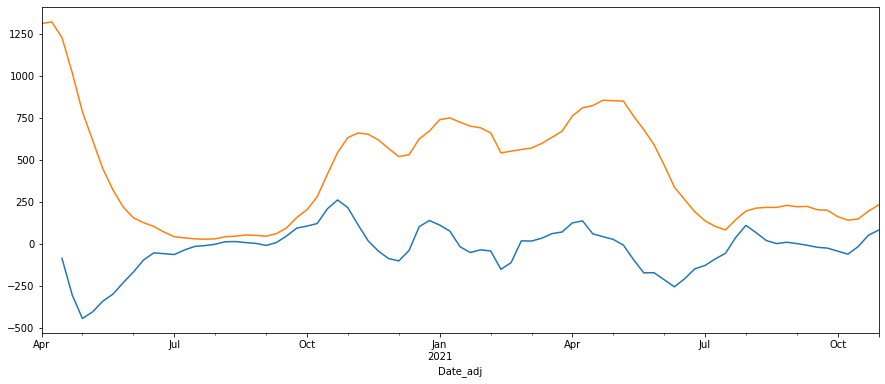

In [6]:
# Get P-value
diff_1 = Index_df_per_dag.diff(2).dropna()
result = adfuller(diff_1)
print("p-value: %f" % result[1])

diff_1.plot(figsize=(15,6))
Index_df_per_dag.plot()

Uit de resultaten van bovenstaande cel blijkt de p-value, die de stationary van de data weergeeft, pas na een diff toe te passen op een waarde onder de 0,05 uit te komen. Hieruit kan geconcludeerd worden dat de d binnen het Arima-model de waarde **2** zou moeten krijgen.

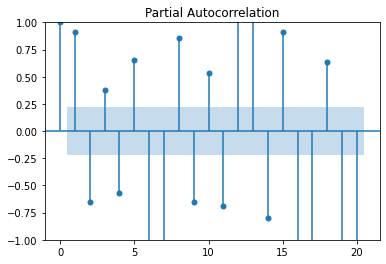

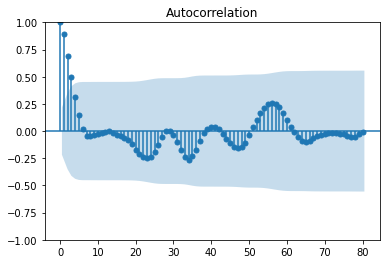

In [7]:
# Find the p, AR-term 
plot_pacf(diff_1)

# Find the q, MA-term
plot_acf(diff_1, lags=len(Index_df_per_dag)-3) # -3 because of the diffence of 1.

plt.show()

Uit de partial autocorrelation blijken alle waardes uit het blauwe gebied te komen, en geeft aan dat enige vorm van autocorrelatie binnen de series te verwijderen is. In de volgende cel wordt de argumented fuller test nogmaals uitgevoerd op gelogde waardes van de data. 

p-value: 0.016083


<AxesSubplot:xlabel='Date_adj'>

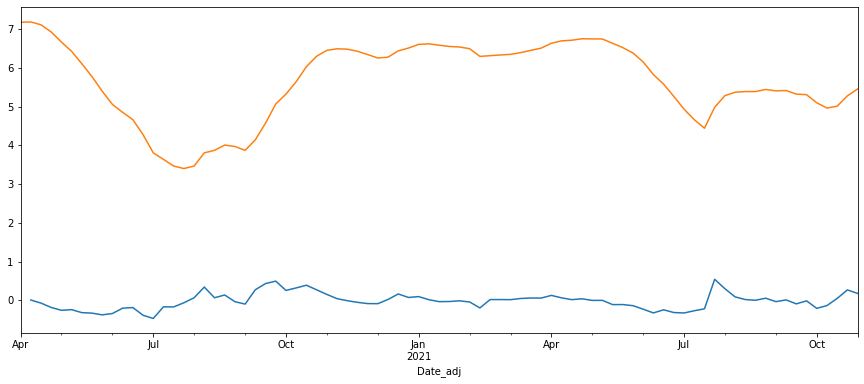

In [8]:
# Get P-value
diff_2 = Index_df_per_dag_log.diff(1).dropna()
result = adfuller(diff_2)
print("p-value: %f" % result[1])

diff_2.plot(figsize=(15,6))
Index_df_per_dag_log.plot()

Uit de resultaten van bovenstaande cel blijkt de p-value, die de stationary van de data weergeeft, pas na een diff toe te passen op een waarde onder de 0,05 uit te komen. Hieruit kan geconcludeerd worden dat de d binnen het Arima-model de waarde **1** zou moeten krijgen. Binnen de volgende cellen wordt gezocht naar de q en p

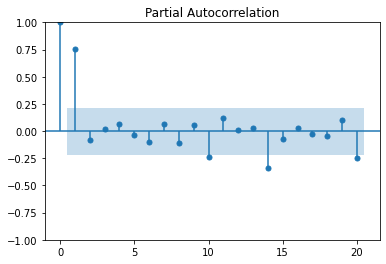

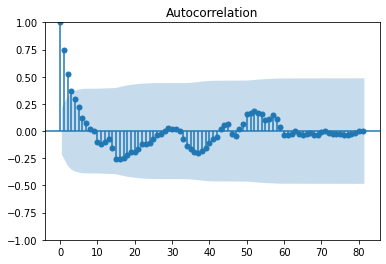

In [9]:
# Find the p, AR-term 
plot_pacf(diff_2)

# Find the q, MA-term
plot_acf(diff_2, lags=len(Index_df_per_dag)-2) # -2 because of the diffence of 1.

plt.show()

De partial autocorrelation bevat nu punten die binnen het blauwe gebied vallen. Naar aanleiding van de partial correlation en autocorrelation dienen p en q de volgende waardes te krijgen:
- p: 1
- q: 2

### Gevonden parameters
----
Naar aanleiding van de bovenstaande grafieken zou de order van ARIMA er als volgt uit moeten zien:
* p &#8594; 1
* d &#8594; 1
* q &#8594; 2
  
Ter validatie wordt in de volgende cel de waardes van p, d en q voorspeld gebruikmakend van pmdarima. Het packet pmdarima maakt het mogelijk de ARIMA-parameters (p,d,q) te bepalen aan de hand van een aantal parameters. In de volgende cel worden aan de hand van de module "auto_arima" de meest passende parameters bepaald. Deze worden net zoals de met de hand uitgerekende parameters later binnen dit notebook getraind. Het ARIMA-model met de laagste Root Mean Squared Error wordt gebruikt voor het voorspellen van de benodigde IC-capaciteit.

In [10]:
def arimamodel(timeseriesarray):

    autoarima_model = pmd.auto_arima(timeseriesarray, 
                              start_p=0, 
                              start_q=0,
                              test="adf",
                              d=None,
                              m=52,
                              approximation=True,
                              Seasonal=True,
                              trace=False)

    return autoarima_model

arimamodel(Index_df_per_dag)

ARIMA(order=(2, 1, 1), scoring_args={}, seasonal_order=(1, 0, 0, 52),
      suppress_warnings=True, with_intercept=False)

Uit de auto_arima-functie komen de volgende parameters:
* p &#8594; 2
* d &#8594; 1
* q &#8594; 1

Naast de standaard ARIMA-order is een optimale seasonal_order gegeven. De optimale seasonal order ziet er als volgt uit:
* P &#8594; 1
* D &#8594; 0
* Q &#8594; 0
* Periode &#8594; 52

De periode heeft de waarde 52 gekregen. Dit getal geeft het aantal stappen weer die nodig zijn om een seasonal period, in dit geval een jaar in weken, te doorlopen. 

In de volgende cel worden twee ARIMA-modellen met beide orders getraind. Van ieder model wordt de Root Mean Squared Error (RMSE) berekend. De order met de laagste RMSE wordt gebruikt om het ARIMA-model te trainen.

In [11]:
orders = np.array([[2,1,1], [1,1,2], [3,1,4], [2,1,3]])
rmse = []

for i in orders:
    model = ARIMA(Index_df_per_dag, order=(i)).fit()
    pred = model.predict(start=len(train), end=(len(Index_df_per_dag) -1))
    rmse_value = np.mean((pred - test.values)**2)**.5
    rmse.append(rmse_value)
    rmse_value

min_rmse = min(rmse)
index_rmse = rmse.index(min_rmse)
best_order = orders[index_rmse]

print("De ARIMA-order met de laagste Root Mean Squared Error is: ",best_order , "met een waarde van: ", min_rmse,".")

De ARIMA-order met de laagste Root Mean Squared Error is:  [2 1 1] met een waarde van:  25.3328227004351 .


Text(0, 0.5, 'Benodigde IC-capaciteit per maand.')

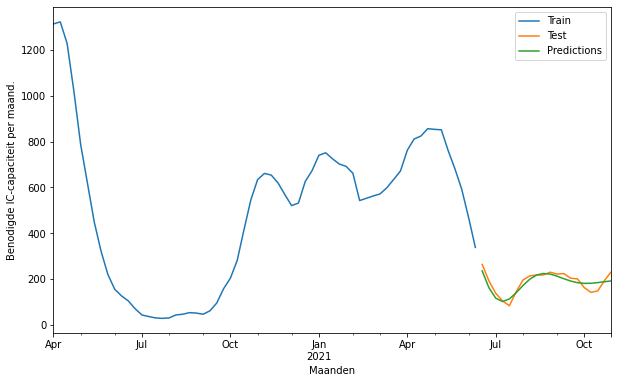

In [12]:
# Build model with the best parameters
model = ARIMA(train, order=(2,1,3)).fit()
pred = model.predict(start=len(train), end=(len(Index_df_per_dag) -1))

#Plot results 
train.plot(legend=True, label="Train", figsize=(10,6))
test.plot(legend=True, label="Test")
pred.plot(legend=True, label="Predictions")
plt.xlabel("Maanden")
plt.ylabel("Benodigde IC-capaciteit per maand.")

Na handmatig de order van het ARIMA-model te hebben aangepast, blijkt de order 2,1,3 het beste overeen te komen met de testdata, ondanks dat deze de hoogste Root Mean Squared Error heeft. Uit de grafiek blijkt dat de predictiewaarden nagenoeg overeen komen met de testwaardes. Hieruit lijkt vooralsnog het model adequaat te zijn. In de volgende cel wordt een ARIMA-model getraind dat dat de IC-capaciteit tot en met 31 oktober 2022 kan voorspellen.

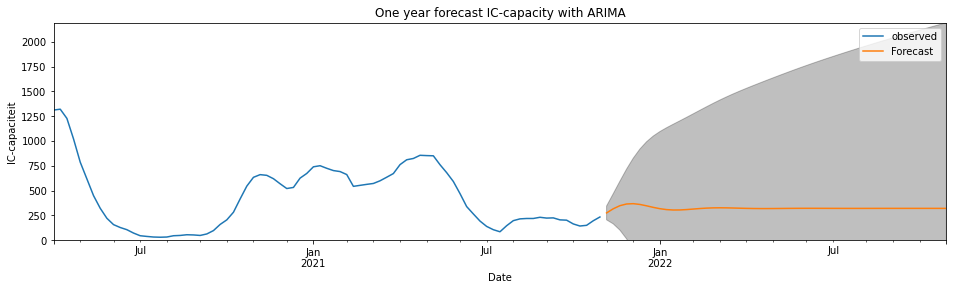

In [22]:
# Predict the future data.
final_model = ARIMA(Index_df_per_dag, order=(2,1,3)).fit()

prediction = final_model.predict(len(Index_df_per_dag), len(Index_df_per_dag) + 52)

# Dezelfde plot als bovenstaande cel, met onzekerheid.
# Get forecast 12 steps ahead in future
pred_uc = final_model.get_forecast(steps=52)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

# Plot the model
ax = Index_df_per_dag.plot(label='observed', figsize=(16,4))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_title("One year forecast IC-capacity with ARIMA")
ax.set_xlabel('Date')
ax.set_ylabel('IC-capaciteit')
ax.set_ylim(0,pred_ci.iloc[:, 1].max())

plt.legend()
plt.show()

De predicties die vanuit het ARIMA-model naar voren zijn gekomen zijn te vinden in bovenstaande grafiek. Binnen de grafiek is te zien dat de oranje lijn (de voorspellingen, na februari 2022 afvlakken. Daarnaast is te zien dat het onzekere gebied, het grijze vlak, steeds onzekerder wordt. Naar aanleiding [van het forum stats.stackexchange](https://stats.stackexchange.com/questions/286900/arima-forecast-straight-line) lijkt de stagnering te komen doordat ARIMA geen rekening kan houden en daardoor seizoenen niet herkend. Een model dat hier wel rekening mee houdt is SARIMA. In het volgende hoofdstuk worden twee SARIMA-modellen getraind met de eerder genoemde orders, namelijk:
1. 2,1,1
2. 1,1,2

## Residual errors
---
Binnen deze paragraaf worden de Residual Errors van het ARIMA-model weergegeven.

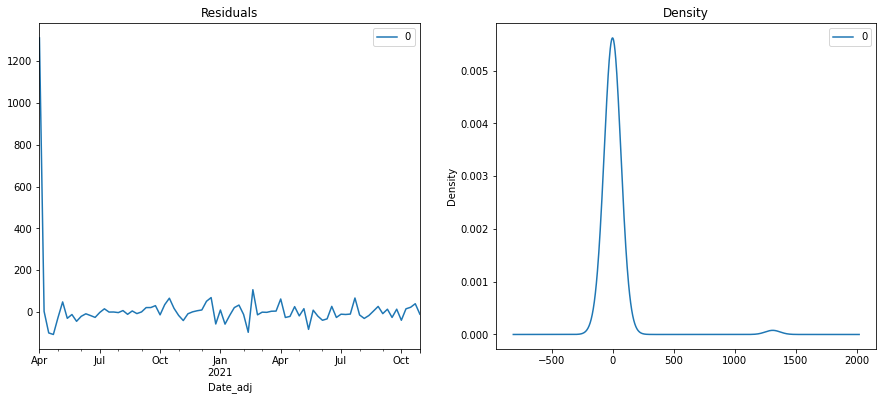

In [14]:
# Plot residual errors
residuals = pd.DataFrame(final_model.resid)
fig, ax = plt.subplots(1,2, figsize=(15,6))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

Binnen de Density grafiek is een kleine bult te zijn tussen de 1000 en 1500, dit kan een mogelijk outlier zijn. In de volgende cel wordt een boxplot weergegeven van de waardes die zich binnen het dataframe Index_df_per_dag bevinden. Dankzij deze boxplot worden eventuele outliers in kaart gebracht.

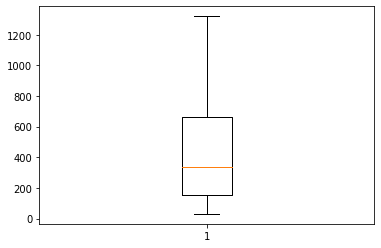

In [15]:
# Boxplot weergeven.
plt.boxplot(Index_df_per_dag)
plt.show()

Binnen het boxplot zijn geen outliers te zien. Hieruit kan geconcludeerd worden dat indien sprake is van een of meerdere outliers deze zo klein zijn dat ze waarschijnlijk het model niet beïnvloeden. 

# SARIMA
---
Binnen dit hoofdstuk wordt de benodigde IC-capaciteit voorspeld met behulp van een SARIMA-model. Alvorens het model getraind wordt dienen de volgende stappen ondernomen te worden:
- Beste order bepalen aan de hand van de Root Mean Squared Error en AIC-score.
- Drie modellen met de drie beste orders.
- Beste model plotten.

In [16]:
from sklearn.metrics import mean_squared_error
from IPython.display import display

orders = np.array([[2,1,1], [1,1,2], [3,1,4], [2,1,3],[2,1,2]])
rmse = []
AIC = []

for i in orders:
    modelS = sm.tsa.statespace.SARIMAX(Index_df_per_dag,
                                order=(i),
                                seasonal_order=(1, 0, 0, 52),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
    resultS = modelS.fit()
    pred = resultS.get_prediction(start=pd.to_datetime('2021-06-20'), dynamic=False)
    y_forecast = pred.predicted_mean
    rmse_value = np.sqrt(mean_squared_error(y_forecast, test))
    rmse.append(rmse_value)
    AIC.append(resultS.aic)

min_rmse = min(rmse)
index_rmse = rmse.index(min_rmse)
best_order = orders[index_rmse]

# Scores van de verschillende ordes weergeven binnen een model.    
scores = np.array([["2,1,1", rmse[0], AIC[0]], ["1,1,2", rmse[1], AIC[1]], ["3,1,4", rmse[2], AIC[2]], ["2,1,3", rmse[3], AIC[3]], ["2,1,2", rmse[4], AIC[4]]])
cols = ["Order", "Root Mean Squared Error", "AIC"] 
num_cols = ["Root Mean Squared Error", "AIC"]
score_table = pd.DataFrame(scores, columns=cols)
score_table[num_cols] = score_table[num_cols].apply(pd.to_numeric)
score_table = score_table.round(2)

display(score_table)

,Order,Root Mean Squared Error,AIC
0,"2,1,1",23.97,276.51
1,"1,1,2",23.83,288.00
2,"3,1,4",22.26,269.65
3,"2,1,3",19.81,274.17
4,"2,1,2",23.63,275.86


Uit de analyse blijken de volgende drie orders de laagste Root Mean Squared Error te hebben:
1. 2,1,3
2. 3,1,4
3. 2,1,2

De volgende orders hebben de laagste AIC-score, dus maken de minste data onbruikbaar:
1. 3,1,4
2. 2,1,3
3. 2,1,2

De drie orders met de laagste Root Mean Squared Error en AIC-score komen allemaal voor in de top drie, enkel de volgorde verschilt. Binnen de volgende worden drie modellen getraind met de best scorende orders. Ieder model wordt vervolgens geplot met de IC-capaciteit van 1 november 2021 tot en met 16 januari 2022. Dit wordt gedaan ter validatie hoe het model zich voordoet in vergelijking met de werkelijkheid.

In [17]:
model1 = sm.tsa.statespace.SARIMAX(Index_df_per_dag,
                                order=(2,1,3),
                                seasonal_order=(1, 0, 0, 52),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

model2 = sm.tsa.statespace.SARIMAX(Index_df_per_dag,
                                order=(2,1,2),
                                seasonal_order=(1, 0, 0, 52),
                                enforce_stationarity=False,
                                enforce_invertibility=False)     

model3 = sm.tsa.statespace.SARIMAX(Index_df_per_dag,
                                order=(3,1,4),
                                seasonal_order=(1, 0, 0, 52),
                                enforce_stationarity=False,
                                enforce_invertibility=False) 

Nu de modellen zijn getraind zijn wordt nagegaan of zij predicties kunnen doen die overeen komen met de testdata. Daarna worden de modellen gebruikt voor de predicties voor de benodigde IC-capciteit voor de periode 1 november 2021 tot en met 1 november 2021. Deze voorspellingen zullen worden vergeleken met de maximale wekelijkse IC-capaciteit van 1 november 2021 tot en met 16 januari 2022.

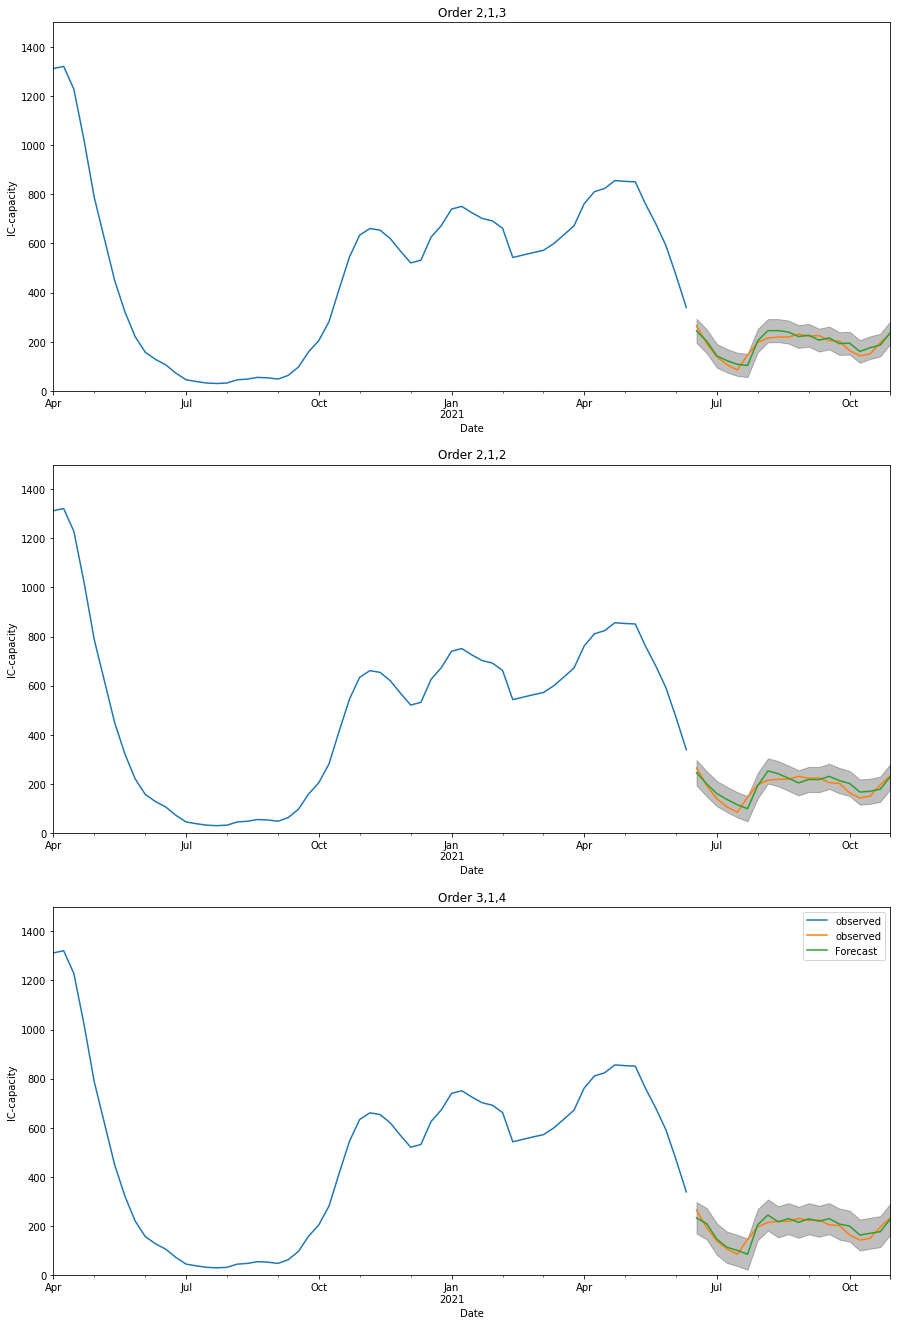

In [18]:
# Plot the results
plt.subplot(3,1,1)
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=3, wspace=0.2, hspace=0.2)

#2,1,1
# Get forecast 52 steps ahead in future
results = model1.fit()
pred_uc = results.get_prediction(start=pd.to_datetime('2021-06-20'), dynamic=False)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

ax = train.plot(label='observed', figsize=(15,6))
ax = test.plot(label='observed', figsize=(15,6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_title("Order 2,1,3")
ax.set_xlabel('Date')
ax.set_ylabel('IC-capacity')
ax.set_ylim(0,1500)

# 1,1,2
results2 = model2.fit()
# Get forecast 52 steps ahead in future
pred_uc = results2.get_prediction(start=pd.to_datetime('2021-06-20'), dynamic=False)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

# Plot the results
plt.subplot(3,1,2)
ax = train.plot(label='observed', figsize=(15,6))
ax = test.plot(label='observed', figsize=(15,6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_title("Order 2,1,2")
ax.set_xlabel('Date')
ax.set_ylabel('IC-capacity')
ax.set_ylim(0,1500)

# 1,1,2
results3 = model3.fit()
# Get forecast 52 steps ahead in future
pred_uc = results3.get_prediction(start=pd.to_datetime('2021-06-20'), dynamic=False)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

# Plot the results
plt.subplot(3,1,3)
ax = train.plot(label='observed', figsize=(15,6))
ax = test.plot(label='observed', figsize=(15,6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_title("Order 3,1,4")
ax.set_xlabel('Date')
ax.set_ylabel('IC-capacity')
ax.set_ylim(0,1500)

plt.legend()
plt.show()

Alle drie de modellen lijken de waardes van de testdata goed te kunnen voorspellen, hierbij is het model dat getraind is met order 3,1,4 het meest consistent te zijn. In de volgende cel worden deze orders gebruikt voor het maken van de predicties van de benodigde IC-capaciteit vanaf 1 november 2021 tot en met 1 november 2022.

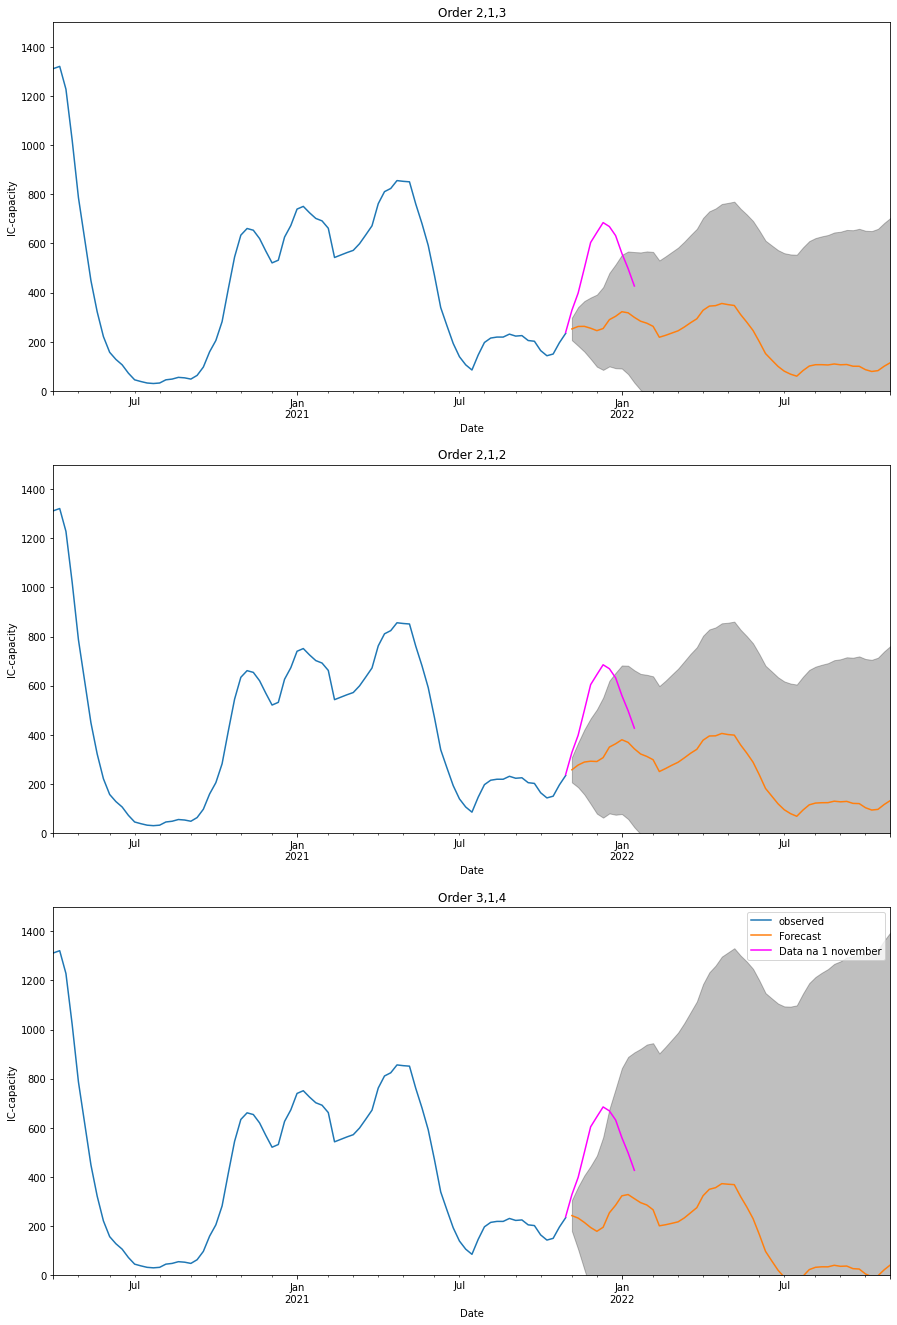

In [19]:
# Data preprocessing van de data na 1 november 2021.
df_per_dag_recent["Datum"] = pd.to_datetime(df_per_dag_recent["Datum"])
df_per_dag_recent = df_per_dag_recent.loc[(df_per_dag_recent["Datum"] >= "2020-04-01") & (df_per_dag_recent["Datum"] < "2022-01-16")]
Index_df_per_dag_recent = df_per_dag_recent[["Aanwezig op IC verdacht of bewezen Corona", "Datum"]]
Index_df_per_dag_recent.set_index(["Datum"], inplace=True)
Index_df_per_dag_recent = Index_df_per_dag_recent["Aanwezig op IC verdacht of bewezen Corona"].resample("W").max()

recent_data = Index_df_per_dag_recent[82:]

# Plot the results
plt.subplot(3,1,1)
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=3, wspace=0.2, hspace=0.2)

# Get forecast 52 steps ahead in future
pred_uc = results.get_forecast(steps=52)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

ax = Index_df_per_dag.plot(label='observed', figsize=(15,6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
recent_data.plot(label="Data na 1 november", color="magenta")
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_title("Order 2,1,3")
ax.set_xlabel('Date')
ax.set_ylabel('IC-capacity')
ax.set_ylim(0,1500)

# Get forecast 52 steps ahead in future
pred_uc = results2.get_forecast(steps=52)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

# Plot the results
plt.subplot(3,1,2)
ax = Index_df_per_dag.plot(label='observed', figsize=(15,6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
recent_data.plot(label="Data na 1 november", color="magenta")
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_title("Order 2,1,2")
ax.set_xlabel('Date')
ax.set_ylabel('IC-capacity')
ax.set_ylim(0,1500)

# Get forecast 52 steps ahead in future
pred_uc = results3.get_forecast(steps=52)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

# Plot the results
plt.subplot(3,1,3)
ax = Index_df_per_dag.plot(label='observed', figsize=(15,6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
recent_data.plot(label="Data na 1 november", color="magenta")
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_title("Order 3,1,4")
ax.set_xlabel('Date')
ax.set_ylabel('IC-capacity')
ax.set_ylim(0,1500)

plt.legend()
plt.show()


De grafieken in bovenstaande cel laten zien dat in beide modellen de magenta lijn aan het einde van november, begin december buiten het grijze gebied komt. De magentalijn lijkt voor een groot deel in het grijze gebied te komen met de order 3,1,4. Echter is binnen dit model ook sprake van de grootste onzekerheid, daarom kan de order 3,1,4 beter niet gekozen worden.

De ARIMA-modellen met de orders 2,1,2 en 2,1,3 lijken in grote lijnen overeen te komen. De vorm van de voorspellingen (de oranje lijn) komt in beide modellen overeen. Het grote verschil zit het hem in de onzeker, in het model met order 2,1,3 is sprake van minder onzekerheid dan bij die met order 2,1,2. Dit blijkt ook uit de lagere Root Mean Squared Error van 2,1,3 ten opzichte van 2,1,2. Op basis van deze bevinding zou het model met order 2,1,3 het meest passende model moeten zijn.

Naar aanleiding van de bevindingen wordt het model met order 2,1,3 nog een keer weergegeven.

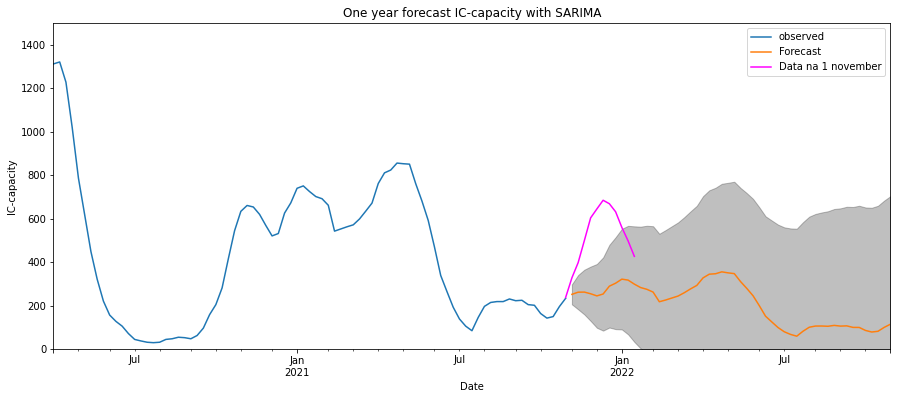

In [21]:
# Get forecast 52 steps ahead in future
pred_uc = results.get_forecast(steps=52)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

ax = Index_df_per_dag.plot(label='observed', figsize=(15,6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
recent_data.plot(label="Data na 1 november", color="magenta")
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_title("One year forecast IC-capacity with SARIMA")
ax.set_xlabel('Date')
ax.set_ylabel('IC-capacity')
ax.set_ylim(0,1500)

plt.legend()
plt.show()

De IC-capaciteit die het SARIMA-model heeft voorspeld zijn te zien in bovenstaande grafiek (en eerdere gerealiseerde grafieken.). Naar aanleiding van de resultaten van het SARIMA-model blijkt de hypothese van [stats.stackexchange](https://stats.stackexchange.com/questions/286900/arima-forecast-straight-line) klopt. De voorspellingen hebben namelijk meer variatie zien. Daarnaast is de onzekerheid (het grijze gebied) aanzienlijk kleiner is dan het geval is bij het ARIMA-model. 

Wanneer het de voorspelling die het SARIMA-model vergeleken worden met de benodigde IC-capaciteit van 1 november 2021 tot en met 16 januari 2022 (de magentakleurige lijn), blijkt het model te rooskleurige voorspellingen te doen. 

# Conclusie
---
Binnen dit hoofdstuk worden de resultaten van de time forecasting analyses geëvalueerd.

## ARIMA
Helaas blijkt ARIMA niet geschikt te zijn voor het voorspellen van de benodigde IC-capaciteit in de toekomst. De plot van het ARIMA-model te zien is voorspeld het ARIMA-model een rechte streep. Daarnaast is sprake van een zeer hoge onzekerheid, dit is weergegeven in de vorm van het grijze gebied. 
De rechte streep binnen de voorspelling die ARIMA doet heeft volgens [het forum stats.stackexchange](https://stats.stackexchange.com/questions/286900/arima-forecast-straight-line) te maken met het feit dat ARIMA geen rekening kan houden met seizoenen. Een model dat op ARIMA gebaseerd is en dit wel kan is SARIMA. De resultaten van dit model worden later in de conclusie beschreven. ![Plot van ARIMA](images\ARIMA_plot.png) 

Het getrainde ARIMA-model heeft de volgende metrics:
* AIC-score: 640,865
* Root Mean Squared Error: 25,33

## SARIMA
Het SARIMA-model maakt zoals het forum stats.stackexchange aangaf inderdaad een betere voorspelling. De plot laat een fluctuerende lijn zien en het onzekere gebied is aanzienlijk minder. Wanneer de voorspelling die het SARIMA-model doet afgewogen worden met de recente data, vanaf 1 november 2021 tot en met 16 januari 2022, blijkt dat het model te rooskleurige voorspellingen doet in vergelijking met de werkelijkheid. Pas sinds januari begint de daadwerkelijk benodigde IC-capaciteit overeen te komen met de voorspellingen, al bevinden deze zich nog in het onzekere gebied. ![Plot van SARIMA](images\SARIMA_plot.png)

Het getrainde SARIMA-model heeft de volgende metrics:
* AIC-score: 274,17
* Root Mean Squared Error: 19,81

In vergelijking met de metrics van het ARIMA-model zijn de metrics van het SARIMA-model iets beter. Uit de metrics blijkt het SARIMA-model beter te zijn in het voorspellen van de benodigde IC-capaciteit in vergelijking het ARIMA-model.


# Aanbevelingen
Gedurende het trainen van de model werd duidelijk dat de hoeveelheid data te gering is. (S)ARIMA-modellen werken over het algemeen het beste met maandelijkse data, omdat deze minder fijn is dan bijvoorbeeld wekelijkse of dagelijkse data. Omdat na het omzetten van de wekelijkse data naar maandelijkse datapunten te weinig datapunten overbleven is besloten de benodigde IC-capaciteit om te zetten naar de wekelijkse maximum IC-capaciteit. Helaas bleken dit te weinig datapunten te zijn om de seizoensgebondenheid te analyseren. Omdat de data om is gezet naar weken is binnen dit notebook als seizoenen de weken aangehouden. Desalniettemin is het aan te raden de analyse naar de seizoenen uit te voeren als hier genoeg data voor is. Naast de binnen dit notebook te realiseren is het aan te raden te analyseren met welke mogelijke seizoenen de benodigde IC-capaciteit te maken heeft gehad, denk hierbij aan:
- Zomer, herfst, winter en lente.
- Wanneer maatregelen getroffen werden.

Vooral het laatste aspect maakt het maken van een goede analyse lastig, aangezien deze in tegenstelling tot de verwachtte winst van een bedrijf niet op voorhand te voorspellen zijn.